In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# set the random seed for reproduction 
SEED=190
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# checking if GPU is available or not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load CelebA from Kaggle public dataset

In [2]:
# set directory 
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

IMG_WIDTH = 178
IMG_HEIGHT = 218

## 1. CelebA Overview

In [3]:
# import the data set that include the attribute for each picture
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')

# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [4]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [5]:
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [6]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling       0
Male          1
Young         0
Eyeglasses    0
Name: 162151.jpg, dtype: int64

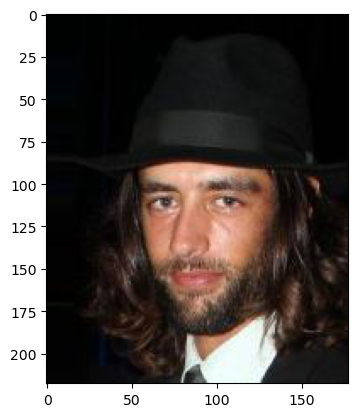

In [7]:
# plot picture and attributes
from tensorflow.keras.utils import load_img
EXAMPLE_PIC = images_folder + '162151.jpg'
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young','Eyeglasses']] #some attributes

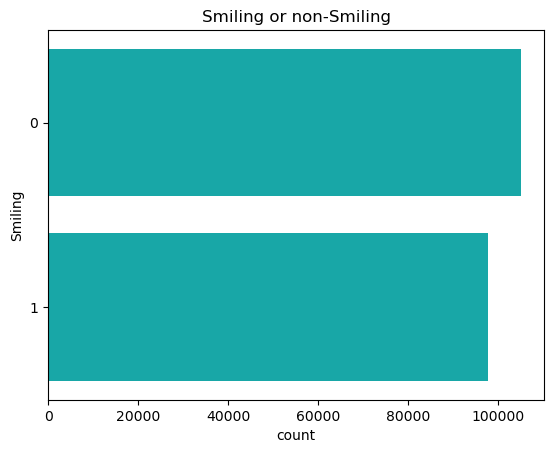

In [8]:
# smiling
plt.title('Smiling or non-Smiling')
sns.countplot(y='Smiling', data=df_attr, color="c")
plt.show()

In [9]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Smiling'], how='inner')
df_par_attr.head()

,partition,Smiling
image_id,,
000001.jpg,0,1
000002.jpg,0,1
000003.jpg,0,0
000004.jpg,0,0
000005.jpg,0,0


## 2.Dataset for Smiling

* **celeba_train.csv** the training dataset. The 'id' is the file name in celeba-dataset
* **celeba_valid.csv** the validation dataset. The 'id' is the file name in celeba-dataset

In [10]:
comp_path = '/kaggle/input/cs190-winter23-deep-learning-mp1'
train_df = pd.read_csv(os.path.join(comp_path, 'celeba_train.csv'))
valid_df = pd.read_csv(os.path.join(comp_path, 'celeba_valid.csv'))

In [11]:
train_df

,id,label
0,124687.jpg,1
1,108662.jpg,1
2,120859.jpg,1
3,149895.jpg,1
4,057043.jpg,1
...,...,...
49995,146578.jpg,0
49996,038177.jpg,0
49997,097024.jpg,0
49998,106276.jpg,0


In [12]:
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from PIL import Image

class CelebADataset(Dataset):
    """
        A customized dataset to load the CelebA image dataset.
    """
    def __init__(self, img_path, imgs, labels, resize=None, inference=False):
        """
            img_path: str, the directory of celeba dataset 
            imgs: List[str], the image file names
            labels: List[int], the 0/1 label for each image
            resize: None or int, whether downsample or upsample the image to certain size
            inference: bool, True for the data without the label
        """
        self.img_path = img_path
        self.resize = resize
        self.imgs = imgs
        self.labels = labels
        self.inference = inference
        
        # Center crop the alingned celeb dataset to 178x178 to include the face area 
        # and then downsample to 128x128 .
        self.pre_process = transforms.Compose([
                                            transforms.CenterCrop((178, 178)),
                                            transforms.Resize((128,128)),
                                            ])

                          
        # first transform the images to tensor format, then normalize the pixel values
        self.totensor = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])
        
        if resize is not None:
            self.resampling = transforms.Resize((resize, resize))
    
    def __getitem__(self, index):
        image_path = os.path.join(self.img_path, self.imgs[index])
        img = Image.open(image_path).convert('RGB')
        img = self.pre_process(img)
        img_tensor = self.totensor(img)
        if self.resize is not None:
            img_tensor = self.resampling(img_tensor)
        if not self.inference:
            label = self.labels[index]
            return img_tensor, label
        else:
            return img_tensor
        
    def __len__(self):
        return len(self.imgs)

In [13]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000

# create the dataset
train_ds = CelebADataset(images_folder, train_df['id'], train_df['label'])
valid_ds = CelebADataset(images_folder, valid_df['id'], valid_df['label'])

# build the dataloader
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_ds, batch_size=TEST_BATCH_SIZE
)

In [14]:
train_ds[0][0].size(), train_ds[0][1]

(torch.Size([3, 128, 128]), 1)

## 3. Define the training and validation loops 

For each epoch:
1. Calculate the loss and the gradient on the training set. Use optimizer to update the parameters. 
2. Calculate the loss and accuracy on the validation set. Save the model when we get a better loss.

In [15]:
class Trainer(object):
    """
        A learning pipeline to train and validate the model.
    """
    def __init__(self, model, criterion, optimizer, max_epoch):
        """
            model: nn model
            criterion: loss function
            optimizer: optimizer
            max_epoch: maximum training epoch
        """
        self.model = model.to(device)
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        
    def run(self,train_loader, valid_loader):
        """
            Main entry
                train_loader: training dataset, each item is (img, label)
                valid_loader: validation dataset, each item is (img, label)
        """
        # calculate the inital loss and accu on validation set
        valid_best_loss = self.validate(-1, valid_loader, best_loss=None)
        for epoch in range(self.max_epoch):
            self.train(epoch, train_loader)
            # save the checkpoint with the lowest validation loss
            valid_best_loss = self.validate(epoch, valid_loader, valid_best_loss)
        
    def train(self, epoch, loader):
        """
            Single training loop
                epoch: int, current epoch index
                loader: training loader
        """
        # switch to the train mode, calculate the gradient
        self.model.train()
        running_loss, total, correct = 0.0, 0, 0
        with tqdm(enumerate(loader, 0), mininterval=10) as tepoch:
            for i, data in tepoch:
                # get the inputs; data is a list of [inputs, labels]
                # inputs: tensor, (batch_size, image_size, image_size)
                # labels: tensor, (batch_size, 1)
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                ########################################################
                # TODO: replace the outputs and loss and update optimizer
                # 1. zero the parameter gradients
                # 2. forward + backward
                # 3. update the parameters
                self.optimizer.zero_grad()
                outputs = model(inputs)
                criterion = nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                #outputs = None
                #loss = None
                ########################################################
                
                # calculate the metric
                match, number = self.cal_metric(outputs.data, labels)
                
                # gather statistics
                total += number
                correct += match
                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        running_loss /= len(loader)

        print('Training | Epoch: {}| Loss: {:.3f} | Accuracy on train images: {:.1f}'.format \
              (epoch+1, running_loss, 100 * correct / total))
        
    def validate(self, epoch, loader, best_loss=None):
        """
            Single evaluation loop
                epoch: int, current epoch index
                loader: validation loader
                best_loss: float, current best loss
        """
        # switch to the evaluation mode, do not need to calculate the gradient
        self.model.eval()
        running_loss, total, correct = 0.0, 0, 0
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            ########################################################
            # TODO: replace the outputs and loss
            self.optimizer.zero_grad()
            outputs = model(inputs)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            #outputs = None
            #loss = None
            ########################################################

            # calculate the metric
            match, number = self.cal_metric(outputs.data, labels)
            
            # gather statistics
            total += number
            correct += match
            running_loss += loss.item()

        running_loss /= len(loader)

        if best_loss is None or running_loss < best_loss:
            # if a better loss appears, save the checkpoint
            save_file = 'best_epoch{}_loss{:.2f}_accu{:.2f}.pt'.format(epoch+1, running_loss, 100 * correct / total)
            print('Save to file: ', save_file)
            torch.save(self.model, save_file)
            
            # overwrite the best_checkpoint.pt file
            torch.save(self.model, 'best_checkpoint.pt')
            
            best_loss = running_loss

        print('Validation | Epoch: {}| Loss: {:.3f} | Accuracy on val images: {:.1f}'.format \
              (epoch+1, running_loss,100 * correct / total))

        return best_loss

                
    def cal_metric(self, outputs, labels):
        """
            Calculate the accuracy
                outputs: tensor (batch_size, number_class), the output of the model
                labels: tensor (batch_size, 1), the ground truth
        """
        # compare predictions to ground truth
        _, predicted = torch.max(outputs, 1)
        number = labels.size(0)
        correct = (predicted == labels).sum().item()
        return correct, number

## 4. Define the Model Structure

In [16]:
class MLP(nn.Module):
    """
        Multilayer perceptron network
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3*128*128, 2)
        )
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.layers(x)
        # F.log_softmax returns the log probabilities of each class
        # of shape (num_samples, num_classes)
        return F.log_softmax(x, dim=1)

In [17]:
class LeNet(nn.Module):
    """
        LeNet architecture
    """
    def __init__(self):
        super().__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = torch.nn.Conv2d(3, 6, kernel_size = 5)
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        ########################################################
        # TODO: replace the input_size
        # figure out the input dimension of the first linear layer
        self.fc1 = torch.nn.Linear(3 * 64 * 64, 120)
        #(128 + 2(1 - 5))/2) + 1(4)
        ########################################################
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 2)

    def forward(self, x):
        
        ########################################################
        # TODO: organize the forward pass
        # Hint: 
        #     1. check the LeNet link above if you are not familiar with it
        #     2. do not forget the activation function F.relu() 
        #     3. you may want to use torch.flatten() before the full connection layer
        #     4. be careful with the dimension
        ########################################################
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [18]:
# Here we use the MLP model as the baseline. You can change it to whatever model you like
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
print(model)
print('Model Parameters ', sum(p.numel() for p in model.parameters()))
print('Trainable Parameters ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

## 5. Training


In [19]:
import torch.optim as optim

NUM_EPOCH = 20
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
trainer = Trainer(model, criterion, optimizer, max_epoch=NUM_EPOCH)

In [20]:
trainer.run(train_loader, valid_loader)

2it [00:21, 10.63s/it]


Save to file:  best_epoch0_loss12.00_accu1.05.pt
Validation | Epoch: 0| Loss: 12.004 | Accuracy on val images: 1.1


782it [06:32,  1.99it/s, accuracy=79, loss=0.129]


Training | Epoch: 1| Loss: 0.428 | Accuracy on train images: 79.0


2it [00:07,  3.58s/it]


Save to file:  best_epoch1_loss0.29_accu87.65.pt
Validation | Epoch: 1| Loss: 0.292 | Accuracy on val images: 87.7


782it [03:00,  4.33it/s, accuracy=90.6, loss=0.333]


Training | Epoch: 2| Loss: 0.229 | Accuracy on train images: 90.6


2it [00:07,  3.72s/it]


Save to file:  best_epoch2_loss0.25_accu89.45.pt
Validation | Epoch: 2| Loss: 0.248 | Accuracy on val images: 89.5


782it [02:58,  4.38it/s, accuracy=91.5, loss=0.463]


Training | Epoch: 3| Loss: 0.207 | Accuracy on train images: 91.5


2it [00:07,  3.74s/it]


Save to file:  best_epoch3_loss0.20_accu91.30.pt
Validation | Epoch: 3| Loss: 0.204 | Accuracy on val images: 91.3


782it [02:58,  4.39it/s, accuracy=91.9, loss=0.28]


Training | Epoch: 4| Loss: 0.195 | Accuracy on train images: 91.9


2it [00:07,  3.55s/it]


Save to file:  best_epoch4_loss0.20_accu91.10.pt
Validation | Epoch: 4| Loss: 0.202 | Accuracy on val images: 91.1


782it [02:59,  4.34it/s, accuracy=92.4, loss=0.0335]


Training | Epoch: 5| Loss: 0.184 | Accuracy on train images: 92.4


2it [00:07,  3.91s/it]


Validation | Epoch: 5| Loss: 0.224 | Accuracy on val images: 90.5


782it [03:00,  4.34it/s, accuracy=92.4, loss=0.127]


Training | Epoch: 6| Loss: 0.183 | Accuracy on train images: 92.4


2it [00:07,  3.72s/it]


Validation | Epoch: 6| Loss: 0.210 | Accuracy on val images: 91.0


782it [02:59,  4.36it/s, accuracy=92.8, loss=0.343]


Training | Epoch: 7| Loss: 0.176 | Accuracy on train images: 92.8


2it [00:07,  3.75s/it]


Save to file:  best_epoch7_loss0.20_accu91.70.pt
Validation | Epoch: 7| Loss: 0.201 | Accuracy on val images: 91.7


782it [02:59,  4.36it/s, accuracy=92.8, loss=0.0286]


Training | Epoch: 8| Loss: 0.174 | Accuracy on train images: 92.8


2it [00:07,  3.56s/it]


Save to file:  best_epoch8_loss0.20_accu91.55.pt
Validation | Epoch: 8| Loss: 0.199 | Accuracy on val images: 91.5


782it [02:58,  4.37it/s, accuracy=93, loss=0.152]


Training | Epoch: 9| Loss: 0.169 | Accuracy on train images: 93.0


2it [00:07,  3.52s/it]


Save to file:  best_epoch9_loss0.20_accu92.10.pt
Validation | Epoch: 9| Loss: 0.195 | Accuracy on val images: 92.1


782it [03:00,  4.33it/s, accuracy=93.1, loss=0.128]


Training | Epoch: 10| Loss: 0.166 | Accuracy on train images: 93.1


2it [00:07,  3.61s/it]


Save to file:  best_epoch10_loss0.18_accu92.80.pt
Validation | Epoch: 10| Loss: 0.182 | Accuracy on val images: 92.8


782it [02:59,  4.35it/s, accuracy=93.3, loss=0.146]


Training | Epoch: 11| Loss: 0.163 | Accuracy on train images: 93.3


2it [00:07,  3.60s/it]


Validation | Epoch: 11| Loss: 0.197 | Accuracy on val images: 91.8


782it [02:59,  4.35it/s, accuracy=93.4, loss=0.299]


Training | Epoch: 12| Loss: 0.160 | Accuracy on train images: 93.4


2it [00:07,  3.54s/it]


Validation | Epoch: 12| Loss: 0.207 | Accuracy on val images: 91.2


782it [03:01,  4.31it/s, accuracy=93.5, loss=0.117]


Training | Epoch: 13| Loss: 0.157 | Accuracy on train images: 93.5


2it [00:07,  3.62s/it]


Validation | Epoch: 13| Loss: 0.194 | Accuracy on val images: 91.9


782it [03:01,  4.31it/s, accuracy=93.6, loss=0.0589]


Training | Epoch: 14| Loss: 0.154 | Accuracy on train images: 93.6


2it [00:07,  3.67s/it]


Validation | Epoch: 14| Loss: 0.186 | Accuracy on val images: 92.2


782it [03:02,  4.28it/s, accuracy=93.7, loss=0.143]


Training | Epoch: 15| Loss: 0.151 | Accuracy on train images: 93.7


2it [00:07,  3.57s/it]


Save to file:  best_epoch15_loss0.17_accu92.90.pt
Validation | Epoch: 15| Loss: 0.169 | Accuracy on val images: 92.9


782it [02:58,  4.37it/s, accuracy=93.9, loss=0.368]


Training | Epoch: 16| Loss: 0.147 | Accuracy on train images: 93.9


2it [00:07,  3.54s/it]


Validation | Epoch: 16| Loss: 0.200 | Accuracy on val images: 91.6


782it [02:59,  4.36it/s, accuracy=93.9, loss=0.313]


Training | Epoch: 17| Loss: 0.146 | Accuracy on train images: 93.9


2it [00:07,  3.53s/it]


Validation | Epoch: 17| Loss: 0.181 | Accuracy on val images: 92.5


782it [02:59,  4.36it/s, accuracy=94.2, loss=0.126]


Training | Epoch: 18| Loss: 0.141 | Accuracy on train images: 94.2


2it [00:07,  3.58s/it]


Validation | Epoch: 18| Loss: 0.184 | Accuracy on val images: 92.0


782it [02:59,  4.36it/s, accuracy=94.3, loss=0.157]


Training | Epoch: 19| Loss: 0.138 | Accuracy on train images: 94.3


2it [00:07,  3.59s/it]


Validation | Epoch: 19| Loss: 0.204 | Accuracy on val images: 92.0


782it [02:59,  4.36it/s, accuracy=94.4, loss=0.232]


Training | Epoch: 20| Loss: 0.133 | Accuracy on train images: 94.4


2it [00:07,  3.52s/it]

Validation | Epoch: 20| Loss: 0.184 | Accuracy on val images: 92.7


## 6. Predict

In [21]:
class TestDataset(Dataset):
    """
        The test dataset module
    """
    def __init__(self, imgs, resize=None):
        """
            Similar with CelebADataset 
                imgs: open images
                resize: None or int, whether downsample or upsample the image to certain size
        """
        self.imgs = imgs
        self.resize = resize
        
        # Center crop the alingned dataset to 178x178 to include the face area 
        # and then downsample to 128x128 .
        self.pre_process = transforms.Compose([
                                            transforms.CenterCrop((178, 178)),
                                            transforms.Resize((128,128)),
                                            ])

                          
        # first transform the images to tensor format, then normalize the pixel values
        self.totensor = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])
        
        if resize is not None:
            self.resampling = transforms.Resize((resize, resize))
    
    def __getitem__(self, index):
        img = self.imgs[index]
        img = self.pre_process(img)
        img_tensor = self.totensor(img)
        if self.resize is not None:
            img_tensor = self.resampling(img_tensor)
        return img_tensor
        
    def __len__(self):
        return len(self.imgs)

In [22]:
TEST_BATCH_SIZE=1000

def predict(model_path, test_file):
    """
        Load the model and use it to predict test file 
    """
    test_data = torch.load(test_file)
    test_dataset = TestDataset(test_data)
    test_loader = torch.utils.data.DataLoader(
                    test_dataset, batch_size=TEST_BATCH_SIZE
                )
    
    model = torch.load(model_path)
    model.eval()
    preds = []
    with torch.no_grad():
        # labels are not available for the actual test set
        for feature in tqdm(test_loader):
            # calculate outputs by running images through the network
            outputs = model(feature.to(device))
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.tolist())

    return preds

In [23]:
model_path = "best_checkpoint.pt"
test_file = "/kaggle/input/cs190-winter23-deep-learning-mp1/test_img.pt"
preds = predict(model_path,test_file)

100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


In [24]:
df = pd.DataFrame({'id': list(range(len(preds))),'label': preds})
df.to_csv('submission.csv', index=False)